<a href="https://colab.research.google.com/github/JLee823/2023-1st-AI-assisted-drug-discovery-SNU/blob/main/AI_in_drug_discovery_Week3_Predicting_pIC50_of_JAK2_inhibitors_with_tree_based_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting activity of JAK2 inhibitors
## Goal of the class
* Practice the **regression model** using biological data

## Janus kinase
Janus kinase (JAK) is a family of intracellular, non-receptor tyrosine kinases that transduce cytokine-mediated signals via the JAK-STAT pathway. They were initially named "just another kinase" 1 and 2 (since they were just two of many discoveries in a PCR-based screen of kinases),[1] but were ultimately published as "Janus kinase". The name is taken from the two-faced Roman god of beginnings, endings and duality, Janus, because the JAKs possess two near-identical phosphate-transferring domains. One domain exhibits the kinase activity, while the other negatively regulates the kinase activity of the first.

![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Protein_JAK2_PDB_2b7a.png/500px-Protein_JAK2_PDB_2b7a.png)

In [14]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


rdkit을 읽어들이자. 

In [15]:
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem

추가적으로 필요한 다음 package들을 읽어들인다. 

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from tqdm import tqdm # to show a progress bar. 

* data was obtained from this reference: https://advances.sciencemag.org/content/4/7/eaap7885

드랍박스의 링크로 부터 파일을 다운로드 받자. 

이를 위해서 wget 프로그램을 이용해서 jak2_data.csv 파일을 다운로드 받는다. 

In [17]:
!wget -O jak2_data.csv https://www.dropbox.com/s/322tzexv1e6wcnb/jak2_data.csv?dl=0

--2023-03-21 01:59:52--  https://www.dropbox.com/s/322tzexv1e6wcnb/jak2_data.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/322tzexv1e6wcnb/jak2_data.csv [following]
--2023-03-21 01:59:52--  https://www.dropbox.com/s/raw/322tzexv1e6wcnb/jak2_data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc609540e4443c9322565a3d3719.dl.dropboxusercontent.com/cd/0/inline/B4ppW5_pPU1IEakjldsh6-Z7cKF3Fb8PVP0qXVQo4xPr_wW4KoYH7MrIeBseNmiMtoxbd4EFyW67YD2GXlkZiFlTBepS9MJvR0ysgacQRJu1UKTZt7y1HqoEsvld2XqooLZ3JzDH8JBEfxHHeCFw0WXIu3-C5lGVxkvKVJiB2ETR_g/file# [following]
--2023-03-21 01:59:52--  https://uc609540e4443c9322565a3d3719.dl.dropboxusercontent.com/cd/0/inline/B4ppW5_pPU1IEakjldsh6-Z7cKF3Fb8PVP0qXVQo4xPr_wW4KoYH7MrIeBseNmiMtoxbd4EF

In [18]:
%%time
fout = open("jak2_data_canonical.csv", "w")
fout.write("SMILES,pIC50\n")

with open("jak2_data.csv") as fp:
  l = fp.readline()
  idx = 0
  for l in fp:
    smiles, ic50 = l.strip().split(',')
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: # if not a valid SMILES.
      continue
    new_smi = Chem.MolToSmiles(mol, canonical=True)
    fout.write(f"{new_smi},{ic50}\n")
    idx += 1
print(f"Total number of converted molecules: {idx}")
fout.close()

Total number of converted molecules: 1911
CPU times: user 964 ms, sys: 6.85 ms, total: 970 ms
Wall time: 990 ms


In [19]:
data = pd.read_csv("jak2_data_canonical.csv") # CSV 파일을 읽어들이자!

In [20]:
data

,SMILES,pIC50
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59
...,...,...
1906,CC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.72
1907,CN1CCN(c2ncc(-c3cnc4[nH]ccc4n3)c(NC3CCCN(S(=O)...,10.76
1908,CC1CN(S(=O)(=O)CC2CCC(N(C)c3[nH]cnc4nccc3-4)CC...,10.78
1909,CS(=O)(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.97


Origianal data에서는 1911 개의 activity 데이터가 존재한다. 

그러나 이 데이터에는 중복 데이터가 존재할 수 있으므로 중복 제거를 pandas DataFrame의 **drop_duplicates**라는 method를 사용해서 제거해준다. 


In [21]:
data.drop_duplicates(subset="SMILES", keep='first', inplace=True, ignore_index=True)

위의 명령을 수행하면 SMILES column을 기준으로 중복인 행을 제거한다. 

keep='first'는 처음 나오는 entry를 유지한다는 뜻이다. 

inplace는 주어진 DataFrame자체를 바로 변경시킨다는 뜻이다. 

* 첫번째 몇 개의 행의 내용을 확인해보자. 

In [22]:
data.head()

,SMILES,pIC50
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59


In [23]:
data.tail()

,SMILES,pIC50
1715,CC(C)CS(=O)(=O)N1CCCC(Nc2nc(N)ncc2-c2cnc3[nH]c...,10.71
1716,CC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.72
1717,CN1CCN(c2ncc(-c3cnc4[nH]ccc4n3)c(NC3CCCN(S(=O)...,10.76
1718,CC1CN(S(=O)(=O)CC2CCC(N(C)c3[nH]cnc4nccc3-4)CC...,10.78
1719,COC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.97


In [24]:
data.describe()

,pIC50
count,1720.000000
mean,7.350105
std,1.213571
min,4.260000
25%,6.557500
50%,7.340000
75%,8.080000
max,10.970000


<Axes: >

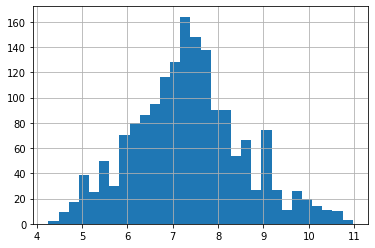

In [25]:
data["pIC50"].hist(bins=30)

## IC50 
The **half maximal inhibitory concentration (IC50)** is a measure of the potency of a substance in inhibiting a specific biological or biochemical function. 

IC50 is a quantitative measure that indicates **how much of a particular inhibitory substance (e.g. drug) is needed to inhibit, in vitro, a given biological process or biological component by 50%.** 

The biological component could be an enzyme, cell, cell receptor or microorganism. IC50 values are typically expressed as molar concentration.

**In general, the IC50 value of a typical drug is around several nM.**

$\mathrm{pIC50} = -\log_{10}(IC50)$

## Let's convert smiles to mols first
-----


SMILES를 mol 타입 변수로 모두 변경하자. 

In [26]:
%%time
mols = [Chem.MolFromSmiles(x) for x in data["SMILES"]]

CPU times: user 418 ms, sys: 25.8 ms, total: 444 ms
Wall time: 448 ms


## Converting Mol instances to feature vectors
-----

### 1. Converting mol to fingerprint
-----

이제 Mol type 변수를 ECFP2 또는 ECFP4의 형태로 변형하여 feature vector로 표현해보자. 


In [27]:
radius = 2; nbits = 1024
fp_list = []
for m in tqdm(mols):
  fp = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nbits) # if radius = 2, then fp is an ECFP4
  fp_list.append(fp.ToList())

100%|██████████| 1720/1720 [00:00<00:00, 7573.93it/s]


In [28]:
fp_df = pd.DataFrame(fp_list)

In [29]:
fp_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1716,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1717,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
1718,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [30]:
fp_df.to_csv("jak2_fp_descriptors.csv")

In [31]:
fp_df.to_pickle("jak2_fp_descriptors.pkl")

### 2. Creating molecular descriptors using RDKit
-----


In [32]:
import numpy as np
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.GraphDescriptors import (BalabanJ, BertzCT, Chi0, Chi0n, Chi0v, Chi1,
                                         Chi1n, Chi1v, Chi2n, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v,
                                         HallKierAlpha, Ipc, Kappa1, Kappa2, Kappa3)

from rdkit.Chem.EState.EState_VSA import (EState_VSA1, EState_VSA10, EState_VSA11, EState_VSA2, EState_VSA3,
                                          EState_VSA4, EState_VSA5, EState_VSA6, EState_VSA7, EState_VSA8, EState_VSA9,
                                          VSA_EState1, VSA_EState10, VSA_EState2, VSA_EState3, VSA_EState4, VSA_EState5,
                                          VSA_EState6, VSA_EState7, VSA_EState8, VSA_EState9,)

from rdkit.Chem.Descriptors import (ExactMolWt, MolWt, HeavyAtomMolWt, MaxAbsPartialCharge, MinPartialCharge,
                                    MaxPartialCharge, MinAbsPartialCharge, NumRadicalElectrons, NumValenceElectrons)
from rdkit.Chem.EState.EState import (MaxAbsEStateIndex, MaxEStateIndex, MinAbsEStateIndex, MinEStateIndex,)
from rdkit.Chem.Lipinski import (FractionCSP3, HeavyAtomCount, NHOHCount, NOCount, NumAliphaticCarbocycles,
                                 NumAliphaticHeterocycles, NumAliphaticRings, NumAromaticCarbocycles, NumAromaticHeterocycles,
                                 NumAromaticRings, NumHAcceptors, NumHDonors, NumHeteroatoms, RingCount,
                                 NumRotatableBonds, NumSaturatedCarbocycles, NumSaturatedHeterocycles, NumSaturatedRings,)
from rdkit.Chem.Crippen import (MolLogP, MolMR,)
from rdkit.Chem.MolSurf import (LabuteASA, PEOE_VSA1, PEOE_VSA10, PEOE_VSA11, PEOE_VSA12, PEOE_VSA13, PEOE_VSA14,
                                PEOE_VSA2, PEOE_VSA3,PEOE_VSA4, PEOE_VSA5, PEOE_VSA6, PEOE_VSA7, PEOE_VSA8, PEOE_VSA9,
                                SMR_VSA1, SMR_VSA10, SMR_VSA2, SMR_VSA3, SMR_VSA4, SMR_VSA5, SMR_VSA6,
                                SMR_VSA7, SMR_VSA8, SMR_VSA9, SlogP_VSA1, SlogP_VSA10, SlogP_VSA11, SlogP_VSA12,
                                SlogP_VSA2, SlogP_VSA3,SlogP_VSA4, SlogP_VSA5, SlogP_VSA6, SlogP_VSA7, SlogP_VSA8,
                                SlogP_VSA9, TPSA,)
from rdkit.Chem.Fragments import (fr_Al_COO, fr_Al_OH, fr_Al_OH_noTert, fr_ArN, fr_Ar_COO, fr_Ar_N, fr_Ar_NH,
 fr_Ar_OH, fr_COO, fr_COO2, fr_C_O, fr_C_O_noCOO, fr_C_S, fr_HOCCN, fr_Imine, fr_NH0, fr_NH1,
 fr_NH2, fr_N_O, fr_Ndealkylation1, fr_Ndealkylation2, fr_Nhpyrrole, fr_SH, fr_aldehyde, fr_alkyl_carbamate,
 fr_alkyl_halide, fr_allylic_oxid, fr_amide, fr_amidine, fr_aniline, fr_aryl_methyl, fr_azide, fr_azo, fr_barbitur,
 fr_benzene, fr_benzodiazepine, fr_bicyclic, fr_diazo, fr_dihydropyridine, fr_epoxide, fr_ester, fr_ether, fr_furan,
 fr_guanido, fr_halogen, fr_hdrzine, fr_hdrzone, fr_imidazole, fr_imide, fr_isocyan, fr_isothiocyan, fr_ketone,
 fr_ketone_Topliss, fr_lactam, fr_lactone, fr_methoxy, fr_morpholine, fr_nitrile, fr_nitro, fr_nitro_arom,
 fr_nitro_arom_nonortho, fr_nitroso, fr_oxazole, fr_oxime, fr_para_hydroxylation, fr_phenol,
 fr_phenol_noOrthoHbond, fr_phos_acid, fr_phos_ester, fr_piperdine, fr_piperzine, fr_priamide, fr_prisulfonamd,
 fr_pyridine, fr_quatN, fr_sulfide, fr_sulfonamd, fr_sulfone, fr_term_acetylene, fr_tetrazole, fr_thiazole, fr_thiocyan,
 fr_thiophene, fr_unbrch_alkane, fr_urea)


def calc_rdkit_descriptors(mol):
    AllChem.ComputeGasteigerCharges(mol)
    if np.isnan(MinPartialCharge(mol)):
        print("NaN!", Chem.MolToSmiles(mol))
        descriptors = None
    else:
        descriptors = [
                BalabanJ(mol) , # 0
                0.0001*BertzCT(mol) , # 1
                0.1*Chi0(mol) , # 2
                0.1*Chi0n(mol) , # 3
                0.1*Chi0v(mol) , # 4
                0.1*Chi1(mol) , # 5
                0.1*Chi1n(mol) , # 6
                0.1*Chi1v(mol) , # 7
                0.1*Chi2n(mol) , # 8
                0.1*Chi2v(mol) , # 9
                0.1*Chi3n(mol) , # 10
                0.1*Chi3v(mol) , # 11
                0.1*Chi4n(mol) , # 12
                0.1*Chi4v(mol) , # 13
                0.01*EState_VSA1(mol) , # 14
                0.01*EState_VSA10(mol) , #15
                0.01*EState_VSA11(mol) , #16
                0.01*EState_VSA2(mol) , #17
                0.01*EState_VSA3(mol) , #18
                0.01*EState_VSA4(mol) ,
                0.01*EState_VSA5(mol) , #20
                0.01*EState_VSA6(mol) ,
                0.01*EState_VSA7(mol) ,
                0.01*EState_VSA8(mol) ,
                0.01*EState_VSA9(mol) ,
                0.001*ExactMolWt(mol) , #25
                FractionCSP3(mol) ,
                HallKierAlpha(mol) ,
                0.01*HeavyAtomCount(mol) ,
                0.001*HeavyAtomMolWt(mol) ,
                0.1*Kappa1(mol) , #30
                0.1*Kappa2(mol) ,
                0.001*Kappa3(mol) ,
                0.01*LabuteASA(mol) ,
                0.1*MaxAbsEStateIndex(mol) ,
                MaxAbsPartialCharge(mol) , #35
                0.1*MaxEStateIndex(mol) ,
                MaxPartialCharge(mol) , #37
                MinAbsEStateIndex(mol) ,
                MinAbsPartialCharge(mol) , #39
                MinEStateIndex(mol) , #40
                MinPartialCharge(mol) ,
                0.1*MolLogP(mol) ,
                0.01*MolMR(mol) ,
                0.001*MolWt(mol) ,
                0.1*NHOHCount(mol) , #45
                0.1*NOCount(mol) ,
                NumAliphaticCarbocycles(mol) ,
                NumAliphaticHeterocycles(mol) ,
                0.1*NumAliphaticRings(mol) ,
                NumAromaticCarbocycles(mol) , #50
                NumAromaticHeterocycles(mol) ,
                NumAromaticRings(mol) ,
                0.1*NumHAcceptors(mol) ,
                0.1*NumHDonors(mol) ,
                0.1*NumHeteroatoms(mol) , #55
                NumRadicalElectrons(mol) ,
                0.1*NumRotatableBonds(mol) ,
                NumSaturatedCarbocycles(mol) ,
                NumSaturatedHeterocycles(mol) ,
                0.1*NumSaturatedRings(mol) , #60
                0.01*NumValenceElectrons(mol) ,
                0.01*PEOE_VSA1(mol) ,
                0.01*PEOE_VSA10(mol) ,
                0.01*PEOE_VSA11(mol) ,
                0.01*PEOE_VSA12(mol) , #65
                0.01*PEOE_VSA13(mol) ,
                0.01*PEOE_VSA14(mol) ,
                0.01*PEOE_VSA2(mol) ,
                0.01*PEOE_VSA3(mol) ,
                0.01*PEOE_VSA4(mol) , #70
                0.01*PEOE_VSA5(mol) ,
                0.01*PEOE_VSA6(mol) ,
                0.01*PEOE_VSA7(mol) ,
                0.01*PEOE_VSA8(mol) ,
                0.01*PEOE_VSA9(mol) , # 75
                0.1*RingCount(mol) ,
                0.01*SMR_VSA1(mol) ,
                0.01*SMR_VSA10(mol) ,
                0.01*SMR_VSA2(mol) ,
                0.01*SMR_VSA3(mol) , # 80
                0.01*SMR_VSA4(mol) ,
                0.01*SMR_VSA5(mol) ,
                0.01*SMR_VSA6(mol) ,
                0.01*SMR_VSA7(mol) ,
                0.01*SMR_VSA8(mol) , #85
                0.01*SMR_VSA9(mol) ,
                0.01*SlogP_VSA1(mol) ,
                0.01*SlogP_VSA10(mol) ,
                0.01*SlogP_VSA11(mol) ,
                0.01*SlogP_VSA12(mol) ,#90
                0.01*SlogP_VSA2(mol) , #91
                0.01*SlogP_VSA3(mol) ,
                0.01*SlogP_VSA4(mol) ,
                0.01*SlogP_VSA5(mol) ,
                0.01*SlogP_VSA6(mol) , #95
                0.01*SlogP_VSA7(mol) ,
                0.01*SlogP_VSA8(mol) , #97
                0.01*SlogP_VSA9(mol) ,
                0.01*TPSA(mol) ,
                0.01*VSA_EState1(mol) ,#100
                0.01*VSA_EState10(mol) ,
                0.01*VSA_EState2(mol) ,
                0.01*VSA_EState3(mol) ,
                0.01*VSA_EState4(mol) ,
                0.01*VSA_EState5(mol) , #105
                0.01*VSA_EState6(mol) ,
                0.01*VSA_EState7(mol) ,
                0.01*VSA_EState8(mol) ,
                0.01*VSA_EState9(mol) ,
                fr_Al_COO(mol) , #110
                fr_Al_OH(mol) ,
                fr_Al_OH_noTert(mol) ,
                fr_ArN(mol) ,
                fr_Ar_COO(mol) ,
                fr_Ar_N(mol) ,
                fr_Ar_NH(mol) ,
                fr_Ar_OH(mol) ,
                fr_COO(mol) ,
                fr_COO2(mol) ,
                fr_C_O(mol) ,
                fr_C_O_noCOO(mol) ,
                fr_C_S(mol) ,
                fr_HOCCN(mol) ,
                fr_Imine(mol) ,
                fr_NH0(mol) ,
                fr_NH1(mol) ,
                fr_NH2(mol) ,
                fr_N_O(mol) ,
                fr_Ndealkylation1(mol) ,
                fr_Ndealkylation2(mol) ,
                fr_Nhpyrrole(mol) ,
                fr_SH(mol) ,
                fr_aldehyde(mol) ,
                fr_alkyl_carbamate(mol) ,
                fr_alkyl_halide(mol) ,
                fr_allylic_oxid(mol) ,
                fr_amide(mol) ,
                fr_amidine(mol) ,
                fr_aniline(mol) ,
                fr_aryl_methyl(mol) ,
                fr_azide(mol) ,
                fr_azo(mol) ,
                fr_barbitur(mol) ,
                fr_benzene(mol) ,
                fr_benzodiazepine(mol) ,
                fr_bicyclic(mol) ,
                fr_diazo(mol) ,
                fr_dihydropyridine(mol) ,
                fr_epoxide(mol) ,
                fr_ester(mol) ,
                fr_ether(mol) ,
                fr_furan(mol) ,
                fr_guanido(mol) ,
                fr_halogen(mol) ,
                fr_hdrzine(mol) ,
                fr_hdrzone(mol) ,
                fr_imidazole(mol) ,
                fr_imide(mol) ,
                fr_isocyan(mol) ,
                fr_isothiocyan(mol) ,
                fr_ketone(mol) ,
                fr_ketone_Topliss(mol) ,
                fr_lactam(mol) ,
                fr_lactone(mol) ,
                fr_methoxy(mol) ,
                fr_morpholine(mol) ,
                fr_nitrile(mol) ,
                fr_nitro(mol) ,
                fr_nitro_arom(mol) ,
                fr_nitro_arom_nonortho(mol) ,
                fr_nitroso(mol) ,
                fr_oxazole(mol) ,
                fr_oxime(mol) ,
                fr_para_hydroxylation(mol) ,
                fr_phenol(mol) ,
                fr_phenol_noOrthoHbond(mol) ,
                fr_phos_acid(mol) ,
                fr_phos_ester(mol) ,
                fr_piperdine(mol) ,
                fr_piperzine(mol) ,
                fr_priamide(mol) ,
                fr_prisulfonamd(mol) ,
                fr_pyridine(mol) ,
                fr_quatN(mol) ,
                fr_sulfide(mol) ,
                fr_sulfonamd(mol) ,
                fr_sulfone(mol) ,
                fr_term_acetylene(mol) ,
                fr_tetrazole(mol) ,
                fr_thiazole(mol) ,
                fr_thiocyan(mol) ,
                fr_thiophene(mol),
                fr_unbrch_alkane(mol) ,
                fr_urea(mol) , #rdkit properties # 196
                ]               
    return descriptors

이제 모든 분자들의 descriptor를 계산하여 

In [33]:
desc_list = []
for m in tqdm(mols):
  desc = calc_rdkit_descriptors(m)
  desc_list.append(desc)

100%|██████████| 1720/1720 [00:46<00:00, 37.31it/s]


In [34]:
desc_df = pd.DataFrame(desc_list)

In [35]:
desc_df

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
0,1.689101,0.113993,1.727781,1.295562,1.458862,1.211612,0.750316,0.986598,0.536235,0.821928,...,0,1,0,0,0,0,0,1,0,0
1,1.470192,0.161964,2.528588,1.866737,1.956180,1.724813,1.085660,1.265420,0.809001,0.986659,...,0,0,0,0,0,0,0,0,0,0
2,2.013741,0.070242,1.639698,1.311095,1.311095,1.109656,0.818758,0.818758,0.627199,0.627199,...,0,0,0,0,0,0,0,0,0,0
3,2.049364,0.067247,1.552673,1.271652,1.271652,1.070271,0.791201,0.791201,0.585589,0.585589,...,0,0,0,0,0,0,0,0,0,0
4,1.976973,0.080089,1.465649,1.149883,1.231532,1.025835,0.657054,0.697878,0.452889,0.493713,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,1.589335,0.114440,2.130275,1.703780,1.785430,1.431450,0.998991,1.159907,0.797115,0.998471,...,0,1,0,0,0,0,0,0,0,0
1716,1.616056,0.092104,1.793251,1.477409,1.477409,1.270351,0.898088,0.898088,0.666841,0.666841,...,0,0,0,0,0,0,0,0,0,0
1717,1.409628,0.136054,2.691564,2.281306,2.362956,1.807143,1.342757,1.503673,1.165754,1.374602,...,0,1,0,0,0,0,0,0,0,0
1718,1.343210,0.089316,2.059565,1.715912,1.797562,1.388618,1.048325,1.209242,0.873419,1.074775,...,0,1,0,0,0,0,0,0,0,0


### 2. Creating molecular descriptors using Mordred
----

Mordred를 설치하자. 

In [36]:
pip install mordred

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.7 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176723 sha256=3bdbf033d62782433a13ac0572f23bd25c143a9a4e6e956c3a0a00db49b8038d
  Stored in directory: /root/.cache/pip/wheels/05/95/d1/9e913738f0e8362b3676917b953a60afd76d2b0b99ff8a71ec
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


In [37]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

In [ ]:
%%time
mordred_df = calc.pandas(mols)

 58%|█████▊    | 1005/1720 [09:16<09:23,  1.27it/s]

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 75%|███████▍  | 1286/1720 [11:51<03:02,  2.38it/s]

In [ ]:
mordred_df

In [ ]:
mordred_df.to_csv("jak2_mordred_descriptors.csv")

In [ ]:
mordred_df.to_pickle("jak2_mordred_descriptors.pkl")

# FingerPrint 기반의 RandomForest 모델 학습

### Feature 와 Target 값을 정의해주자. 
-----
1. 첫번째로 ECFP2 fingerprint를 feature vector로 사용하고 pIC50 값을 target value로 설정하자. 


In [ ]:
X = fp_df
y = data["pIC50"]

In [ ]:
X

In [ ]:
y

In [ ]:
y.hist(bins=20)

## Training set과 test set을 나누자!
* sklearn의 train_test_split 함수를 이용하면 손쉽게 분리할 수 있다. 

In [ ]:
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train[:10] # 학습용 데이터

In [ ]:
X_test[:10] # 평가용 데이터

In [ ]:
y_train[:10]

In [ ]:
y_test[:10]

## Let's perform regression prediction using RandomForest
-------

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

## 빈 모델을 하나 생성

In [ ]:
my_model = RandomForestRegressor(random_state=42)

## 실제로 학습 진행!

In [ ]:
%%time
my_model.fit(X_train, y_train)

### 모델 평가
-----
* test 셋의 정보를 주고 목적값을 예측. 
* predict method사용. 

In [ ]:
y_pred = my_model.predict(X_test)

In [ ]:
y_pred

## 회귀 예측이 잘 되었는지 확인하자!
### scatter plot을 그려보자!

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()

### 기준선 (y==x), 완벽한 예측의 경우, 를 추가해서 그려보자
-------

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50", fontsize='xx-large')
plt.ylabel("Predicted pIC50", fontsize='xx-large')
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error

### 오차를 계산해보자.
-------

#### Mean Sqaured Error (MSE)
-----

* regression에서 가장 많이 사용하는 측정치는 mean squared error 이다. 
* 평균 제곱 오차

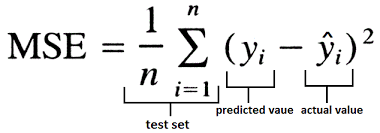

In [ ]:
mse1 = mean_squared_error(y_test, y_pred)

In [ ]:
print(f"Mean Squared Error of this model is {mse1:.3f} (pIC50 unit)")

#### Pearson correlation coefficient
------

<img src="https://editor.analyticsvidhya.com/uploads/39170Formula.JPG" width="500">

In [ ]:
np.corrcoef(y_test, y_pred)

In [ ]:
print(f"Pearson's correlation coefficient of our model is {np.corrcoef(y_test,y_pred)[0,1]:.3f}")

최종적으로 우리가 ECFP4를 이용해서 학습시킨 모델은 
MSE 0.49 pIC50 value (0.68 kcal/mol) 정도의 오차를 가지고, 
상관 계수 0.832를 가진다는 것을 확인할 수 있었다. 



# 1.2: 이번에는 유사한 문제를 classification 문제로 치환하여 풀어보자. 
--------

일반적으로 1~10 $\mu$M 이하의 IC50 값을 가질 때, active한 hit molecule이라고 판단한다. 

이번 예제에서 사용하는 데이터에는 낮은 IC50 값을 가지는 분자들이 많으므로 기준을 조금 더 높게 잡아서 0.1 $\mu$M의 IC50 값을 active와 inactive의 기준으로 삼아서 binary classification을 수행하는 모델을 만들어보자. 


일단 주어진 pIC50 값을 기반으로 pIC50가 6이 넘는 경우 True, 그렇지 않은 경우 False로 변환시켜 준다. 

In [ ]:
y_binary = [t > 7.0 for t in y]

In [ ]:
np.sum(y_binary)

Active한 분자의 개수가 1068개임을 알 수 있다. 

조금 더 다루기 쉽도록 pandas의 Series instance로 바꾸어주자. 

In [ ]:
y_binary = pd.Series(y_binary)

In [ ]:
y_binary.describe()

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [ ]:
y_train.head()

In [ ]:
X_train.head()

Classifier 모델을 선언하자. 

RandomForestClassifier에 관한 자세한 설명은 아래의 공식 문서를 참고하자.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
clf = sklearn.ensemble.RandomForestClassifier()

In [ ]:
%%time
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred

이제 이항 분류기의 성능을 검증하자. 

이항 분류 문제의 성능을 검증하는데에는 여러가지 기준 값(metric)들이 있다. 

* scikit-learn에 구현되어 있는 metric 함수들. 
https://scikit-learn.org/stable/modules/model_evaluation.html

이 중에서 이항 분류의 경우, accuracy, recall, MCC, F1-score등이 많이 사용된다. 

<img src="https://miro.medium.com/v2/format:webp/0*-oGC3SE8sPCPdmxs.jpg" width="800">

<img src="https://www.researchgate.net/publication/268874045/figure/fig3/AS:295410393468929@1447442734103/The-definitions-of-confusion-matrix-derived-accuracy-measures.png" width="800">


In [ ]:
# accuracy
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
# Recall (sensitivity)
recall = sklearn.metrics.recall_score(y_test, y_pred)
# Precision 
prec = sklearn.metrics.precision_score(y_test, y_pred)
print(f"Accuracy:  {acc:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"Precision: {prec:.3f}")

많이 사용되는 accuracy, recall, precision 값들은 True와 False의 비율이 맞지 않을 경우, 잘 못된 결과를 줄 가능성이 높다. 

따라서 balaced measure인 F1-score나 Matthews correlation coefficient 값을 사용하는 것이 일반적으로 더 좋다. 

F1-score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

MCC: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html#sklearn.metrics.matthews_corrcoef

In [ ]:
# F1-score
f1=sklearn.metrics.f1_score(y_test, y_pred)

# MCC
mcc=sklearn.metrics.matthews_corrcoef(y_test, y_pred)

In [ ]:
print(f"F1-score: {f1:.3f}")
print(f"MCC:      {mcc:.3f}")

### ROC 곡선 그리기 
------
Receiver operating characteristic (ROC) curve는 분류 모델의 성능을 비교하기 위해서 많이 사용되는 곡선이다. 

일반적으로 ROC 곡선은 prediction probability를 기준으로 sorting한 후, False positive rate (FPR)을 X축으로 하고, True positive rate (TRP)을 Y축으로 하여 그리게 된다. 

따라서 이상적인 predictor의 경우, 곡선이 왼쪽 위에 붙게 되고 곡선 아래의 영역의 넓이 (Area under the curve, AUC)는 1이 된다. 

반대로 랜덤하게 예측되는 경우, 대각선을 따르게 되고, AUC 값은 0.5가 된다. 

따라서 AUC 값이 1에 가까울 수록 더 좋은 classifier라는 것을 의미한다. 

ROC 곡선은 다음과 같이 **RocCurveDisplay** 함수를 이용해서 그릴 수 있다. 


In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
fig=plt.figure(figsize=(12,12))
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Active vs. Inactive prediction ROC curve")
plt.tight_layout()
plt.legend()
plt.show()

무작위 예측에 (0.5) 어느 정도 모델의 성능이 좋은지 확인할 수 있다. 

# RDKit descriptor를 input으로 사용한 모델을 만들어 보자. 
-------


In [ ]:
X = desc_df
y = data["pIC50"]

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

In [ ]:
X_train.tail()

In [ ]:
X_test.head()

In [ ]:
X_test.tail()

In [ ]:
rdkit_desc_model = RandomForestRegressor()

In [ ]:
%%time
rdkit_desc_model.fit(X_train, y_train)

In [ ]:
y_pred = rdkit_desc_model.predict(X_test)

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50", fontsize='xx-large')
plt.ylabel("Predicted pIC50", fontsize='xx-large')
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()

In [ ]:
desc_model_mse = mean_squared_error(y_test, y_pred)
desc_model_corr = np.corrcoef(y_test, y_pred)

In [ ]:
print(f"Mean Squared Error:       {desc_model_mse:.3f}")
print(f"Correlation Coefficient:  {desc_model_corr[0,1]:.3f}")

## 트리의 개수를 증가시켜서 모델을 학습시켜보자!

In [ ]:
desc_model_v2 = RandomForestRegressor(n_estimators=300, random_state=42)

In [ ]:
%%time
desc_model_v2.fit(X_train, y_train)

In [ ]:
y_pred2 = desc_model_v2.predict(X_test)

In [ ]:
desc_mse2 = mean_squared_error(y_test, y_pred2)

In [ ]:
print(desc_mse2)

In [ ]:
print(f"Previous MSE: {desc_model_mse:.3f}")
print(f"Current MSE:  {desc_mse2:.3f}")

In [ ]:
plt.scatter(y_test, y_pred, marker='.', color='r', label="Ntree=100")
plt.scatter(y_test, y_pred2, marker='.', color='b', label='Ntree=300')
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()

# Tree 개수 500개에 도전!

In [ ]:
my_model_v3 = RandomForestRegressor(n_estimators=500, random_state=42)

In [ ]:
%%time
my_model_v3.fit(X_train, y_train)

In [ ]:
y_pred_v3 = my_model_v3.predict(X_test)

In [ ]:
mse3 = mean_squared_error(y_test, y_pred_v3)

In [ ]:
print(f"Mean Squared Error: {mse3:.3f}")

* 에러가 조금 증가했다!
* 이 결과는 트리 개수를 늘리는 것이 항상 모델의 정확도를 향상시키지는 않는다는 것을 보여준다. 


그렇다면, 최적의 트리 개수는 몇 개 일까? 

default option말고 option을 바꾸어 주면 더 좋은 결과를 얻을 수 있을까? 

이러한 물음에 답하기 위해서 수행할 수 있는 방법을 바로 hyperparameter optimization이라고 부른다. 

이는 다음 시간에 좀 더 깊이 있게 다루도록 하겠다. 

# Feature Importance 확인. 

In [ ]:
desc_model_v2.feature_importances_

In [ ]:
importances = desc_model_v2.feature_importances_
std = np.std([tree.feature_importances_ for tree in desc_model_v2.estimators_], axis=0)

In [ ]:
forest_importances = pd.Series(importances)

In [ ]:
import pandas as pd

fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
forest_importances

In [ ]:
forest_importances.sort_values(ascending=False)

In [ ]:
forest_importances.sort_values(ascending=False)[:20]

In [ ]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
forest_importances.sort_values(ascending=False)[:20].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI", fontsize=32)
ax.set_ylabel("Mean decrease in impurity", fontsize=32)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.tight_layout()

## 예제: MorganFingerprint를 사용하여 feature importance 분석을 해보자. 

In [ ]:
fp_importance = pd.Series(my_model.feature_importances_)

In [ ]:
fp_importance

In [ ]:
fp_importance_sorted = fp_importance.sort_values(ascending=False)

In [ ]:
fp_importance_sorted

In [ ]:
max_idx = fp_importance_sorted.index[0]
print(f"The most important bit index is {max_idx}")

In [ ]:
print("These are the top bit indices")
print("="*30)
for idx in range(20):
  print(f"Rank\t{idx}\t{fp_importance_sorted.index[idx]}")

In [ ]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
fp_importance_sorted[:20].plot.bar(ax=ax)
ax.set_title("Feature importances using ECFP2 bits", fontsize=32)
ax.set_ylabel("Mean decrease in impurity", fontsize=32)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.tight_layout()

In [ ]:
from rdkit.Chem import Draw

In [ ]:
# Set the max_rows option to None to print all rows
pd.set_option('display.max_rows', None)

In [ ]:
print(data["SMILES"][fp_df[max_idx]==1])

In [ ]:
last_idx = data["SMILES"][fp_df[max_idx]==1].index[-1]
print(last_idx)

In [ ]:
data["SMILES"].iloc[last_idx]

In [ ]:
mol=Chem.MolFromSmiles(data["SMILES"].iloc[last_idx])

In [ ]:
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nbits, bitInfo=bi)

In [ ]:
bi

In [ ]:
Draw.DrawMorganBit(mol, fp_importance_sorted.index[0], bi)

# Using XGBoost
-------
XGBoost는 Gradient Boosting 방법을 이용한 Tree-based algorithm입니다. 

Original reference: https://arxiv.org/abs/1603.02754
Project page: https://xgboost.readthedocs.io/en/stable/
github: https://github.com/dmlc/xgboost

많은 경우 RandomForest방법에 비해서 좋은 성능을 주는 것으로 알려져있으며 데이터 기반 예측 경진대회인 Keggle에서 가장 많이 우승한 방법 중의 하나입니다. 

https://www.kaggle.com/

최근의 colab은 xgboost 라이브러리를 기본으로 제공합니다. 

xgboost 모듈을 불러옵시다. 

In [ ]:
import xgboost

In [ ]:
xgboost.__version__

In [ ]:
X_train[:10]

In [ ]:
X_train.describe()

In [ ]:
y_train.head()

In [ ]:
# create model instance
bst = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred_xg = bst.predict(X_test)

In [ ]:
xg_mse = mean_squared_error(y_test, y_pred_xg)

In [ ]:
print(f"Mean Squared Error of the default XGBoost method: {xg_mse:.3f}")

# 연습1: fingerprint의 bit를 2048로 늘려서 학습시켜 보자. 



# 연습2: Mordred package를 이용해서 만든 descriptor를 이용해서 학습시켜보자. 

# 연습3: ExtraTree method를 이용해서 비슷한 모델을 학습시켜 보자. 
----
Scikit-learn에는 RandomForest외에도 다양한 Tree-based algorithm들이 구현되어 있다. 
그 중의 하나가 ExtraTree algorithm이다. 

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

ExtraTree algorithm을 이용해서 같은 데이터 학습을 수행해보고 더 나은 결과를 얻을 수 있는지 확인해보라. 
